In [1]:
# Step 1: Import Libraries
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# Step 2: Setup and Download Dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown


In [3]:
with zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
# Step 3: Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [5]:
train_ds = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

Found 16000 images belonging to 2 classes.


In [6]:
val_ds = train_datagen.flow_from_directory(
    '/content/train',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 4000 images belonging to 2 classes.


In [7]:
# Step 4: Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(256, 256, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [9]:
# Step 5: Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Step 6: Setup Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

In [11]:
# Step 7: Train Model
history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 354s 686ms/step - accuracy: 0.5653 - loss: 2.4817 - val_accuracy: 0.5997 - val_loss: 0.8191
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 341s 683ms/step - accuracy: 0.6196 - loss: 0.6531 - val_accuracy: 0.6068 - val_loss: 0.6631
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 675ms/step - accuracy: 0.6824 - loss: 0.5942 - val_accuracy: 0.6848 - val_loss: 0.5722
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 337s 674ms/step - accuracy: 0.7273 - loss: 0.5499 - val_accuracy: 0.7300 - val_loss: 0.5277
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 338s 676ms/step - accuracy: 0.7488 - loss: 0.5110 - val_accuracy: 0.7558 - val_loss: 0.5066
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 380s 672ms/step - accuracy: 0.7637 - loss: 0.4900 - val_accuracy: 0.7393 - val_loss: 0.5293
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 378s 664ms/step - accuracy: 0.7883 - loss: 0.4490 - val_accuracy: 0.6055 - val_loss: 0.6640
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 335s 670ms/step - accuracy: 0.8026 -

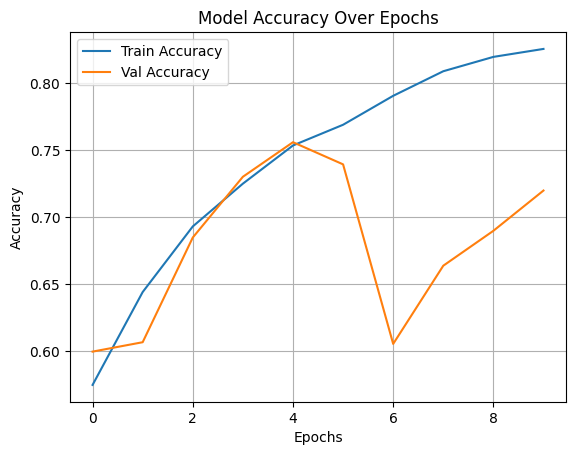

In [12]:
# Step 8: Evaluate & Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

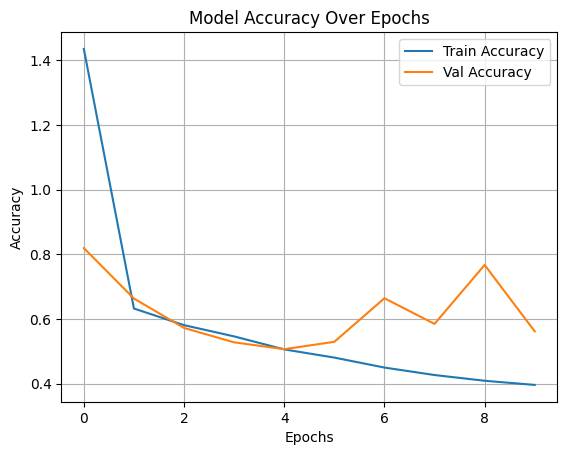

In [13]:
# Step 8: Evaluate & Plot
plt.plot(history.history['loss'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()